In [1]:
%pylab
%matplotlib inline

Using matplotlib backend: <object object at 0x10eda01f0>
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
from gfcat_utils import *

In [3]:
import numpy as np
from astropy.io import fits as pyfits
from astropy import wcs as pywcs
from astropy.visualization import simple_norm, ZScaleInterval
import imageio

In [4]:
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [5]:
eclipse = 3090
e = str(eclipse).zfill(5)
tmpdir = "/Users/cm/GFCAT/gfcat/tmp/"
lc_filename = f"/Users/cm/github/gphoton_working/test_data/e{e}/e{e}-nd-30s-photom-12_8.csv"
fn = f"/Users/cm/github/gphoton_working/test_data/e{e}/e{e}-nd-full-rice.fits"
fn_mov = f"/Users/cm/github/gphoton_working/test_data/e{e}/e{e}-nd-30s-rice.fits"


In [6]:
lc = parse_lightcurves(lc_filename)
x = np.array([source['xcenter'] for source in lc])
y = np.array([source['ycenter'] for source in lc])
cps = np.array([np.nanmean(source['cps']) for source in lc])
print(f"{len(lc)} sources found")
print(lc[0].keys())

13523 sources found

dict_keys(['counts', 'edge_flags', 'mask_flags', 'cps', 'cps_err', 'xcenter', 'ycenter', 'ra', 'dec'])

In [7]:
variables = screen_gfcat([3090],aper_radius=12.8,photdir="/Users/cm/github/gphoton_working/test_data")
print(variables)

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.90s/it]


{3090: [9194, 11286]}

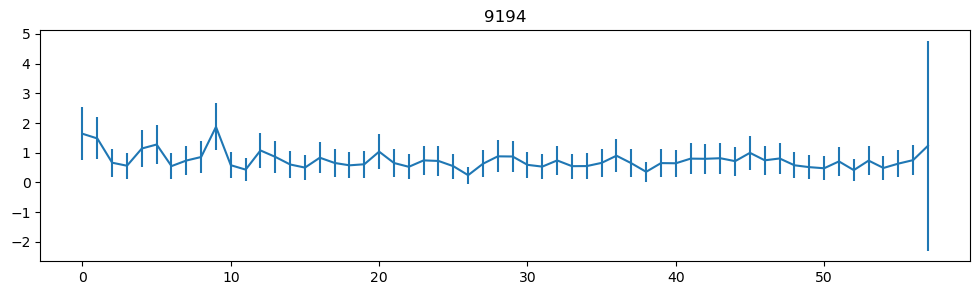

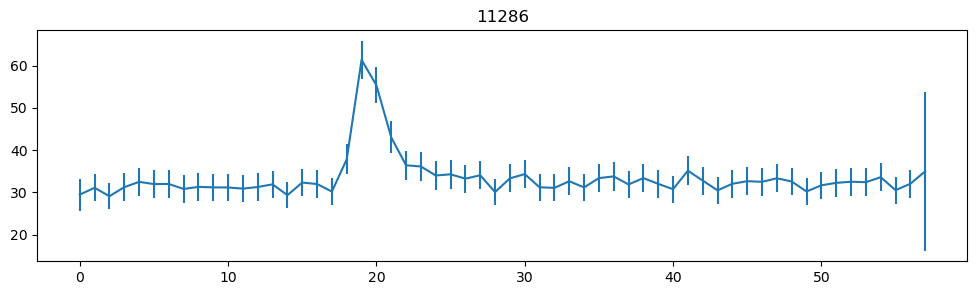

In [8]:
for i in variables[3090]:
    plt.figure(figsize=(12,3))
    plt.title(i)
    t = np.arange(len(lc[i]['counts']))
    plt.errorbar(t,lc[i]['cps'],yerr=lc[i]['cps_err']*3)

In [9]:
movmap,flagmap,edgemap,wcs,tranges,exptimes=read_image(fn_mov,hdunum=1)
movmap[np.where(np.isinf(movmap))]=0 # because it pops out with inf values... IDK
movmap[np.where(movmap<0)]=0

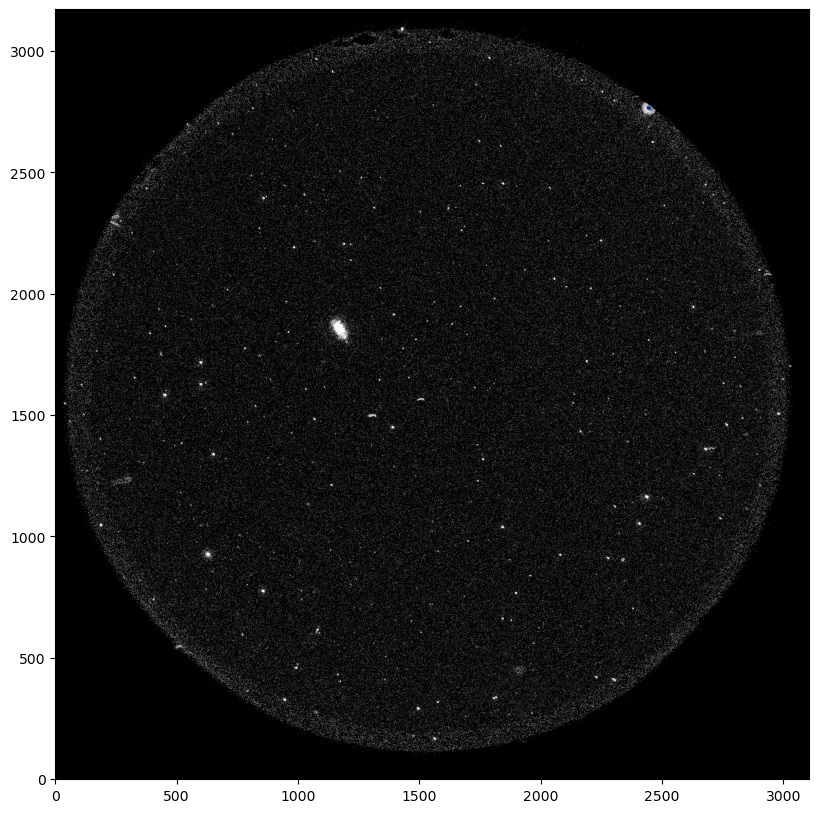

In [11]:
plt.figure(figsize=(10,10));
# M, N, 3 or M, N, 4
opacity = (edgemap[10]+flagmap[10])/2
plt.imshow(edgemap[10],origin="lower",cmap="Reds",alpha=opacity);
plt.imshow(flagmap[10],origin="lower",cmap="Blues",alpha=opacity);
plt.imshow(np.stack([ZScaleInterval()(movmap[10]),
                     ZScaleInterval()(movmap[10]),
                     ZScaleInterval()(movmap[10]),
                     1-opacity],axis=2),origin="lower");

In [12]:
source_ix = 11286
assert len(lc[source_ix]['cps'])==np.shape(movmap)[0]
imgx,imgy = lc[source_ix]['xcenter'],lc[source_ix]['ycenter']

In [35]:
if not os.path.exists(f'{tmpdir}/e{eclipse}/'):
    os.makedirs(f'{tmpdir}/e{eclipse}/')

imsz = np.shape(movmap[0])

# crop on the subframe
boxsz = 200
x1, x2, y1, y2 = (max(int(imgy - boxsz),0),
                  min(int(imgy + boxsz),imsz[0]),
                  max(int(imgx - boxsz),0),
                  min(int(imgx + boxsz),imsz[1]))

# crop on the full frame
x1_,x2_,y1_,y2_ = (max(int(imsz[0]/2-imsz[0]/2),0),
                   min(int(imsz[0]/2+imsz[0]/2),imsz[0]),
                   max(int(imsz[1]/2-imsz[0]/2),0),
                   min(int(imsz[1]/2+imsz[0]/2),imsz[1]))


gs = gridspec.GridSpec(nrows=4, ncols=6)#, height_ratios=[1, 1, 2])

# write individual frames of the animated gif
for i,frame in enumerate(movmap): # probably eliminate the first / last frame, which always has lower exposure
    fig = plt.figure(figsize=(12,9));
    fig.tight_layout()
    ax = fig.add_subplot(gs[:3,:3])
    opacity = (edgemap[i]+flagmap[i])/2
    # M, N, 3 or M, N, 4
    ax.imshow(edgemap[i][x1_:x2_,y1_:y2_],origin="lower",cmap="Reds",alpha=opacity[x1_:x2_,y1_:y2_])
    ax.imshow(flagmap[i][x1_:x2_,y1_:y2_],origin="lower",cmap="Blues",alpha=opacity[x1_:x2_,y1_:y2_])
    ax.imshow(np.stack([ZScaleInterval()(frame[x1_:x2_,y1_:y2_]),
                         ZScaleInterval()(frame[x1_:x2_,y1_:y2_]),
                         ZScaleInterval()(frame[x1_:x2_,y1_:y2_]),
                         1-opacity[x1_:x2_,y1_:y2_]],axis=2),origin="lower")
    ax.set_xticks([])
    ax.set_yticks([])
    rect = Rectangle((y1-y1_, x1-x1_), 2*boxsz, 2*boxsz, linewidth=1, edgecolor='y', facecolor='none',ls='solid')
    ax.add_patch(rect)

    ax = fig.add_subplot(gs[:3,3:])
    ax.imshow(edgemap[i][x1:x2,y1:y2],origin="lower",cmap="Reds",alpha=opacity[x1:x2,y1:y2])
    ax.imshow(flagmap[i][x1:x2,y1:y2],origin="lower",cmap="Blues",alpha=opacity[x1:x2,y1:y2])
    ax.imshow(np.stack([ZScaleInterval()(frame[x1:x2,y1:y2]),
                         ZScaleInterval()(frame[x1:x2,y1:y2]),
                         ZScaleInterval()(frame[x1:x2,y1:y2]),
                         1-opacity[x1:x2,y1:y2]],axis=2),origin="lower")
    ax.set_xticks([])
    ax.set_xticks([])
    ax.set_yticks([])
    circ = Circle((boxsz,boxsz),20,linewidth=1,edgecolor='y',facecolor='none',ls='solid')
    ax.add_patch(circ)
    
    ax = fig.add_subplot(gs[3:,:])
    ax.set_xticks([])
    t = np.arange(len(lc[source_ix]['cps']))
    cps = lc[source_ix]['cps']
    cps_err = lc[source_ix]['cps_err']
    ax.vlines(t[i],min(cps),max(cps),ls='dotted')
    ax.scatter(t[i],cps[i],c='y',s=100,marker='o')
    ax.errorbar(t,cps,yerr=cps_err*3,fmt='k.-')

    plt.savefig(f'{tmpdir}/e{eclipse}/e{eclipse}_movie_{str(i).zfill(2)}.png',dpi=200)
    plt.close()

In [36]:
n_frames = np.shape(movmap)[0]
# write the animated gif
with imageio.get_writer(f'{tmpdir}/e{eclipse}/e{eclipse}.gif', mode='I', fps=4) as writer:
    for i in np.arange(n_frames):
        image = imageio.imread(f'{tmpdir}/e{eclipse}/e{eclipse}_movie_{str(i).zfill(2)}.png')
        writer.append_data(image)